# **INFO-6156 - Capstone Project**

## **Team Members:**

* Aondokator Joseph
* Bernardo Xavier da Silva
* Great Chinwuba-Anemeje
* Stanley Maxwell Imoisili

# **Waste/Recyclables Segmentation using Deep Learning**

# **Cyclotek.AI**

This project aims to build a deep learning model for waste and recyclables segmentation. The model can detect and segment waste items at two levels:
1. **Item Level**: Identify specific items like "bottle", "can", "bag", etc.
2. **Material Level**: Classify materials like "paper", "metal", "plastic", etc.

The model is built using TensorFlow and Python, and it leverages the COCO and Waste Classification datasets.

# **Import Libraries**

In [ ]:
# Install missing packages
# %pip install pycocotools
# %pip install opencv-python
# %pip install tensorflow

# Import libraries
import os
import requests
import zipfile
from pycocotools.coco import COCO
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# **Download Datasets**

In [1]:
"""I already wrote the code that downloads the dataset in another file to allow us focus on the main work here"""

'I already wrote the code that downloads the dataset in another file to allow us focus on the main work here'

# **Preprocess Datasets**

In [ ]:
# Define recyclable material categories
# RECYCLABLE_CATEGORIES = [
#     "bottle", "cup", "bowl", "fork", "knife", "spoon", "book", "vase",
#     "tv", "laptop", "mouse", "remote", "keyboard", "cell phone", "scissors"
# ]

RECYCLABLE_CATEGORIES = ['bottle', 'can', 'bag']

In [ ]:
# Preprocess coco dataset
def preprocess_coco_dataset(coco_dir):
    annotation_path = os.path.join(coco_dir, "annotations/instances_train2017.json")
    image_dir = os.path.join(coco_dir, "train2017")

    # Initialize COCO API
    coco = COCO(annotation_path)

    # Get category IDs for recyclable materials
    cat_ids = coco.getCatIds(catNms=RECYCLABLE_CATEGORIES)
    img_ids = coco.getImgIds(catIds=cat_ids)
    images = coco.loadImgs(img_ids)

    data = []
    for img in images:
        img_path = os.path.join(image_dir, img['file_name'])
        ann_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(ann_ids)

        # Load image and mask
        image = cv2.imread(img_path)
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        for ann in anns:
            mask = np.maximum(mask, coco.annToMask(ann) * ann['category_id'])

        # Resize image and mask
        image = cv2.resize(image, (224, 224))
        mask = cv2.resize(mask, (224, 224))

        data.append((image, mask))

    return data

In [6]:
# Preprocess coco dataset
coco_data = preprocess_coco_dataset("/content/datasets/coco")

loading annotations into memory...
Done (t=17.04s)
creating index...
index created!


In [7]:
len(coco_data)

8501

### **Display some samples**

In [8]:
# Visualization of Samples
def visualize_samples(data, title="Sample Images and Masks", num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Get a random sample
        idx = np.random.randint(0, len(data))
        image, mask = data[idx]

        # Plot image
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        plt.title(f"Image {i + 1}")
        plt.axis("off")

        # Plot mask
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(mask, cmap="gray")
        plt.title(f"Mask {i + 1}")
        plt.axis("off")

    plt.suptitle(title)
    plt.show()

Visualizing samples from the training data...


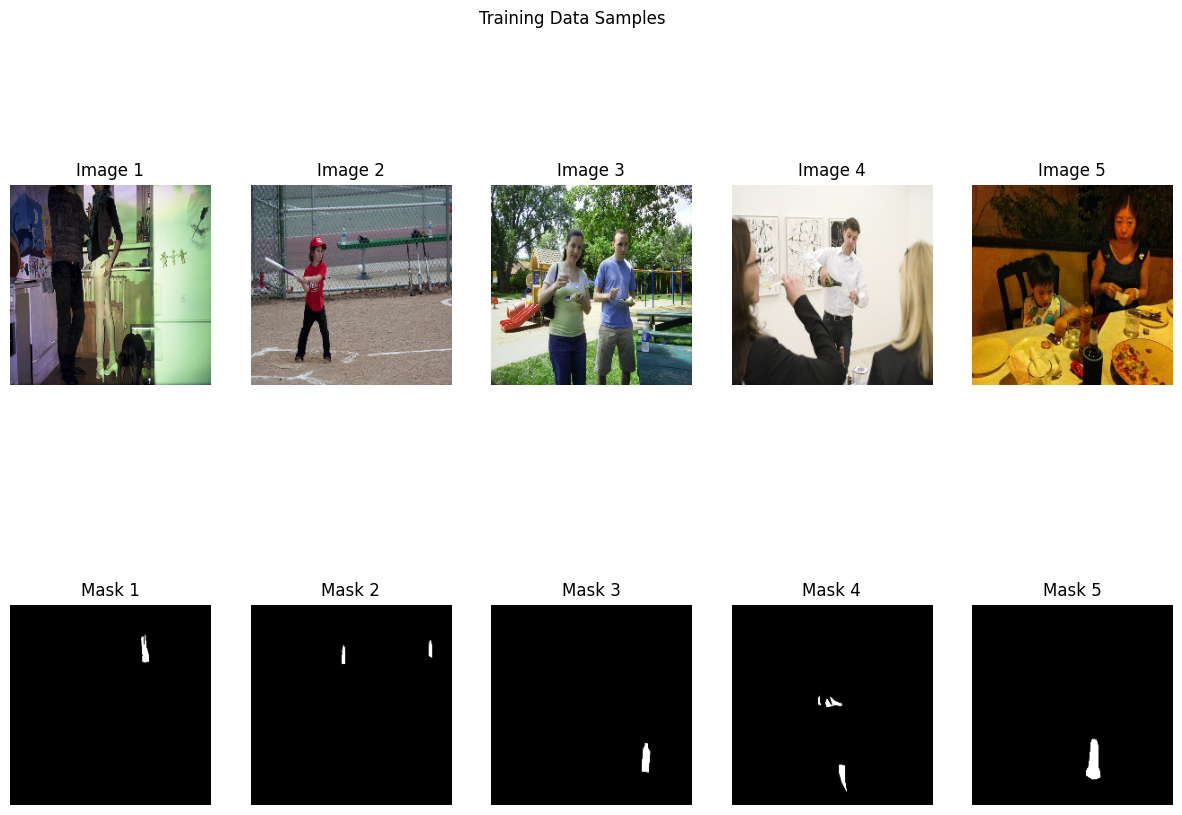

In [9]:
# Visualize samples from the coco dataset
print("Visualizing samples from the training data...")
visualize_samples(coco_data, title="Training Data Samples")

### **Split the dataset in train/val/test**

In [3]:
# Split into training, validation, and testing sets
train_data, test_data = train_test_split(coco_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

NameError: name 'coco_data' is not defined

In [11]:
# Save preprocessed data
def save_data(data, filename):
    """Saves image and mask data separately to avoid inhomogeneous shape errors."""
    images = np.array([item[0] for item in data])
    masks = np.array([item[1] for item in data])
    # Added error handling to check if the file is saved correctly
    try:
        np.save(filename + "_images.npy", images)
        np.save(filename + "_masks.npy", masks)
        print(f"Data saved to {filename}_images.npy and {filename}_masks.npy")
    except Exception as e:
        print(f"Error saving data to {filename}: {e}")

# Save the data
save_data(train_data, "/content/datasets/train_data")
save_data(val_data, "/content/datasets/val_data")
save_data(test_data, "/content/datasets/test_data")

print("Dataset preprocessing complete!")

Data saved to /content/datasets/train_data_images.npy and /content/datasets/train_data_masks.npy
Data saved to /content/datasets/val_data_images.npy and /content/datasets/val_data_masks.npy
Data saved to /content/datasets/test_data_images.npy and /content/datasets/test_data_masks.npy
Dataset preprocessing complete!


# **Build and Train the model**

In [12]:
# Load preprocessed data
# train_data = np.load("/content/datasets/train_data.npy", allow_pickle=True)
# val_data = np.load("/content/datasets/val_data.npy", allow_pickle=True)


try:
    train_data = np.load("/content/datasets/train_data_images.npy", allow_pickle=True)
    train_masks = np.load("/content/datasets/train_data_masks.npy", allow_pickle=True)  # Load masks separately
    val_data = np.load("/content/datasets/val_data_images.npy", allow_pickle=True)
    val_masks = np.load("/content/datasets/val_data_masks.npy", allow_pickle=True)  # Load masks separately
    print("Data loaded successfully!")

    # Recombine images and masks
    train_data = list(zip(train_data, train_masks))
    val_data = list(zip(val_data, val_masks))
except FileNotFoundError:
    print("Error: One or more data files not found. Please make sure the files exist and the path is correct.")
except Exception as e:
    print(f"Error loading data: {e}")

Data loaded successfully!


In [13]:
# Prepare data
X_train = np.array([item[0] for item in train_data])
y_train = np.array([item[1] for item in train_data])
X_val = np.array([item[0] for item in val_data])
y_val = np.array([item[1] for item in val_data])

In [ ]:
# Normalize images to [0, 1]
X_train = X_train / 255.0
X_val = X_val / 255.0

In [ ]:
# Convert masks to categorical format
num_classes = len(RECYCLABLE_CATEGORIES) + 1  # Add 1 for background
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

In [ ]:
# Build U-Net with a pretrained ResNet50 encoder
def build_unet_with_pretrained_encoder(input_shape, num_classes):
    # Load ResNet50 as the encoder
    resnet = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

    # Freeze the encoder layers (optional)
    for layer in resnet.layers:
        layer.trainable = False

    # Encoder (ResNet50)
    encoder_output = resnet.output

    # Decoder
    x = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(encoder_output)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # Output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(x)

    # Create the model
    model = models.Model(resnet.input, outputs)
    return model

In [ ]:
# Build the model
input_shape = (224, 224, 3)
model = build_unet_with_pretrained_encoder(input_shape, num_classes)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32)

print("Model training complete!")

In [ ]:
# Save the model
model.save("/content/drive/MyDrive/path/to/save/recyclable_materials_unet_resnet50.h5")

print("Model saved as 'recyclable_materials_unet_resnet50.h5'")

# **Evaluate model**

In [ ]:
# Load preprocessed test data
test_data = np.load("datasets/test_data.npy", allow_pickle=True)
X_test = np.array([item[0] for item in test_data])
y_test = np.array([item[1] for item in test_data])

In [ ]:
# Load the trained model
model = tf.keras.models.load_model("recyclable_materials_unet_resnet50.h5")

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# **Visualize results**

In [ ]:
# Load a sample image and mask
sample_image = X_test[0]
sample_mask = y_test[0]

In [ ]:
# Predict the mask
predicted_mask = model.predict(np.expand_dims(sample_image, axis=0))[0]
predicted_mask = np.argmax(predicted_mask, axis=-1)

In [ ]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(sample_mask, cmap='jet')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap='jet')

plt.show()